# Unet based DL recon 
## env:DL_recon
## Version:  
    v0: 20230301
## xing lu@ UCSD

In [1]:
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from matplotlib import pyplot as plt

from pytorch_unet import UNet

from time import gmtime, strftime, time
import warnings
warnings.filterwarnings(action='ignore')

# Dataset

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models


class MRIDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.dir = r'/mnt/data2/DLProjects/DL_CSdata_Unet/Code/pytorch-unet'
        self.csv = 'UTE_DLrecon_50.csv'
        self.subset = subset
        self.csv_file = os.path.join(self.dir,self.csv)
        self.df = self.parse_csv(self.csv_file, self.subset)
        self.df.reset_index(drop=True, inplace=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        data_path = self.df.loc[idx, 'image_pth']
        
#         print(data_path)

        data = sio.loadmat(data_path)
    
        image = data['recon']
        label = data['label']
        F_recon = data['recon_factor']
        
        if self.transform:
            image = self.transform(image)
        
        return [image, label]
    @staticmethod
    def parse_csv(csv_file, subset):
        data_frame = pd.read_csv(csv_file)
        data_frame = data_frame[data_frame['valid'] == int(subset)]
        return data_frame

In [3]:
# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = MRIDataset(subset='0',transform=trans)
val_set = MRIDataset(subset='1',transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 16

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 576, 'val': 64}

torch.Size([16, 1, 256, 256]) torch.Size([16, 256, 256])
8160.961 679566.5 148762.97 101700.805
5053.5615 705472.0 141547.11 106107.945


(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f2657e0b190>)

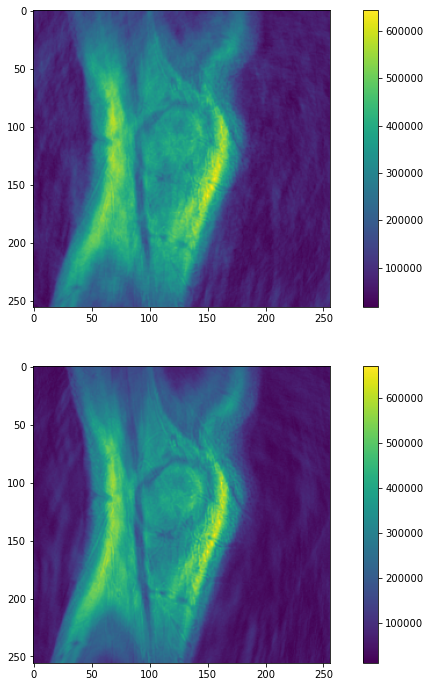

In [4]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
#     inp = np.clip(inp, 0, 1)
#     inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())
plt.figure(figsize=[12,12])
plt.subplot(211),plt.imshow(reverse_transform(inputs[10])),plt.colorbar()
plt.subplot(212),plt.imshow(masks[10]),plt.colorbar()

# model training

In [5]:
import torch
import torch.nn as nn
from pytorch_unet_qMRI import UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1,1)
model = model.to(device)

In [13]:
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
from loss import dice_loss
import pytorch_ssim
from tqdm.notebook import tqdm


def calc_loss_recon(pred, target, metrics):
#     criterion = nn.MSELoss(reduction='mean')
    criterion = nn.L1Loss(reduction='mean')
    
    loss = criterion(pred,target)
    
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    
    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    lr_lst = []
    train_lst = []
    valid_lst = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss_recon(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            if phase == 'train':
                train_lst.append(epoch_loss)
            else:
                valid_lst.append(epoch_loss)    

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_lst,valid_lst

In [31]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = UNet(1,1).to(device)
train_lst = []
valid_lst = []

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.3)

model,train_lst,valid_lst = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=300)

cuda:3


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0/299
----------
LR 0.001
train: loss: 97818.198785
val: loss: 65957.220703
saving best model
0m 21s
Epoch 1/299
----------
LR 0.001
train: loss: 76465.685330
val: loss: 67770.475586
0m 21s
Epoch 2/299
----------
LR 0.001
train: loss: 77165.970920
val: loss: 66847.489258
0m 21s
Epoch 3/299
----------
LR 0.001
train: loss: 75687.446615
val: loss: 63974.730469
saving best model
0m 21s
Epoch 4/299
----------
LR 0.001
train: loss: 81660.354384
val: loss: 65041.515625
0m 22s
Epoch 5/299
----------
LR 0.001
train: loss: 74782.691515
val: loss: 64306.044922
0m 22s
Epoch 6/299
----------
LR 0.001
train: loss: 71399.576931
val: loss: 60623.103516
saving best model
0m 22s
Epoch 7/299
----------
LR 0.001
train: loss: 70395.367513
val: loss: 63412.166992
0m 22s
Epoch 8/299
----------
LR 0.001
train: loss: 69073.568359
val: loss: 59349.315430
saving best model
0m 22s
Epoch 9/299
----------
LR 0.001
train: loss: 67350.274848
val: loss: 59785.951172
0m 22s
Epoch 10/299
----------
LR 0.001
train

train: loss: 61660.375868
val: loss: 56402.534180
0m 22s
Epoch 85/299
----------
LR 8.999999999999999e-05
train: loss: 61665.187609
val: loss: 57333.109375
0m 22s
Epoch 86/299
----------
LR 8.999999999999999e-05
train: loss: 61735.974284
val: loss: 56739.433594
0m 22s
Epoch 87/299
----------
LR 8.999999999999999e-05
train: loss: 61558.939019
val: loss: 57158.704102
0m 22s
Epoch 88/299
----------
LR 8.999999999999999e-05
train: loss: 61630.902886
val: loss: 58483.983398
0m 22s
Epoch 89/299
----------
LR 2.6999999999999996e-05
train: loss: 61454.252821
val: loss: 57321.500000
0m 22s
Epoch 90/299
----------
LR 2.6999999999999996e-05
train: loss: 61412.817600
val: loss: 56885.195312
0m 22s
Epoch 91/299
----------
LR 2.6999999999999996e-05
train: loss: 61498.100803
val: loss: 57114.429688
0m 22s
Epoch 92/299
----------
LR 2.6999999999999996e-05
train: loss: 61481.199870
val: loss: 56938.390625
0m 22s
Epoch 93/299
----------
LR 2.6999999999999996e-05
train: loss: 61428.636827
val: loss: 5647

train: loss: 61265.679036
val: loss: 56937.500000
0m 22s
Epoch 162/299
----------
LR 2.4299999999999996e-06
train: loss: 61321.045030
val: loss: 57168.972656
0m 22s
Epoch 163/299
----------
LR 2.4299999999999996e-06
train: loss: 61325.657878
val: loss: 56991.931641
0m 22s
Epoch 164/299
----------
LR 2.4299999999999996e-06
train: loss: 61325.165473
val: loss: 57126.376953
0m 22s
Epoch 165/299
----------
LR 2.4299999999999996e-06
train: loss: 61328.233941
val: loss: 56959.416016
0m 22s
Epoch 166/299
----------
LR 2.4299999999999996e-06
train: loss: 61309.108724
val: loss: 56994.885742
0m 22s
Epoch 167/299
----------
LR 2.4299999999999996e-06
train: loss: 61252.791233
val: loss: 57127.300781
0m 22s
Epoch 168/299
----------
LR 2.4299999999999996e-06
train: loss: 61249.232964
val: loss: 56934.500000
0m 22s
Epoch 169/299
----------
LR 2.4299999999999996e-06
train: loss: 61230.958876
val: loss: 57156.350586
0m 22s
Epoch 170/299
----------
LR 2.4299999999999996e-06
train: loss: 61257.325412
va

val: loss: 57071.464844
0m 22s
Epoch 238/299
----------
LR 2.1869999999999994e-07
train: loss: 61265.197917
val: loss: 57007.391602
0m 22s
Epoch 239/299
----------
LR 6.560999999999998e-08
train: loss: 61272.699870
val: loss: 57075.645508
0m 22s
Epoch 240/299
----------
LR 6.560999999999998e-08
train: loss: 61326.896701
val: loss: 57032.133789
0m 22s
Epoch 241/299
----------
LR 6.560999999999998e-08
train: loss: 61273.712131
val: loss: 56950.105469
0m 22s
Epoch 242/299
----------
LR 6.560999999999998e-08
train: loss: 61208.851562
val: loss: 56969.156250
0m 22s
Epoch 243/299
----------
LR 6.560999999999998e-08
train: loss: 61127.802517
val: loss: 57036.680664
0m 22s
Epoch 244/299
----------
LR 6.560999999999998e-08
train: loss: 61292.621419
val: loss: 56993.058594
0m 22s
Epoch 245/299
----------
LR 6.560999999999998e-08
train: loss: 61163.225260
val: loss: 57042.049805
0m 22s
Epoch 246/299
----------
LR 6.560999999999998e-08
train: loss: 61300.593641
val: loss: 57078.825195
0m 22s
Epoch

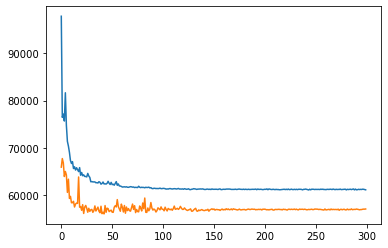

In [33]:
plt.figure()
plt.plot(train_lst)
plt.plot(valid_lst)

In [34]:
inputs, masks = next(iter(dataloaders['train']))

In [35]:
pred = model(inputs.to(device))

In [36]:
test = pred[10].squeeze().detach().cpu()
test.shape

torch.Size([256, 256])

(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f2600f9c990>)

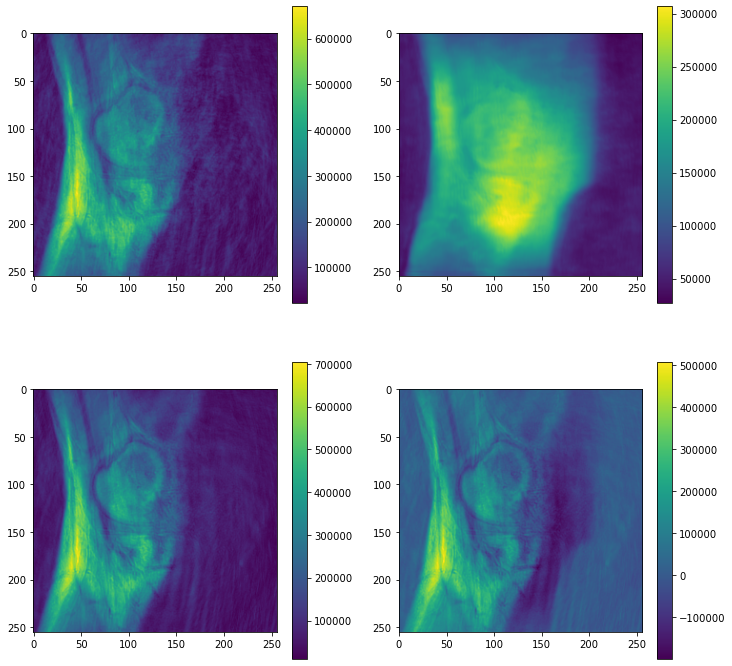

In [37]:
plt.figure(figsize=[12,12])
plt.subplot(221),plt.imshow(reverse_transform(inputs[10])),plt.colorbar()
plt.subplot(222),plt.imshow(reverse_transform(pred[10].detach().cpu())),plt.colorbar()
plt.subplot(223),plt.imshow(masks[10]),plt.colorbar()
plt.subplot(224),plt.imshow(masks[10]-test),plt.colorbar()